In [15]:
import pandas as pd

df = pd.read_csv(r'.\dataset\PRICE.csv')

import datetime as dt
def GetWeekDate(year, week):
    d = "{}-W{}".format(year, week)
    r = dt.datetime.strptime(d + '-0', "%Y-W%W-%w")
    return r

df['date'] = df[['YEAR','WEEK']].apply(lambda x : GetWeekDate(x[0],x[1]), axis=1)

df['date'] = pd.to_datetime(df['date'])

df.set_index('date', inplace=True)

df = df.fillna(method="ffill")

df.drop(columns=['YEAR', 'WEEK'], axis=1, inplace=True)

df1=df.copy()

In [16]:
input_cols = [c for c in df.columns if c not in ['SALES AMOUNT','WEEK','YEAR']] # 'CATEGORY'
input_cols

['CATEGORY',
 'SKU',
 'SYSTEM PRICE',
 "Competitor's price",
 'NetCost',
 'UNITS',
 'REAL PRICE',
 'MIN TEMP',
 'AVG TEMP',
 'MAX TEMP',
 'RAIN INTENSITY',
 'PROMOTION']

In [17]:
drop_cols=[c for c in df.columns if c not in ['SKU','UNITS']]

i=0
for sku in df.SKU.unique():
    df2=df[(df.SKU == sku)].copy()
    df2['single_input_vector'] = df2[input_cols].apply(tuple, axis=1).apply(list)
    df2['single_input_vector'] = df2.single_input_vector.apply(lambda x: [list(x)])
    df2['cumulative_input_vectors'] = df2.single_input_vector.cumsum()
    df2.drop(drop_cols, 1, inplace=True)
    if(i!=0):
        dft=dft.append(df2)
    else:
        dft=df2.copy()
    i=i+1
output_cols=['UNITS']
dft['output_vector'] = dft[output_cols].apply(tuple, axis=1).apply(list)
pd.set_option('display.max_colwidth',1000)
print(dft[(dft.SKU == 101)]['cumulative_input_vectors'])
print(dft.columns)
print(len(dft.SKU.unique()))

date
2013-07-28                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           [[1.0, 101.0, 28.11, 32.55, 27.94, 154.0, 30.71, 16.14, 21.43,

In [21]:
import numpy as np
from keras.preprocessing.sequence import pad_sequences

max_sequence_length = dft.cumulative_input_vectors.apply(len).max()
print(max_sequence_length)
# Save it as a list   

dft_seq_len=dft.copy()
dft_seq_len['seq_len']=dft_seq_len[['cumulative_input_vectors']].apply(lambda x: len(x[0]), axis=1)
dft_seq_len=dft_seq_len.groupby('SKU')['seq_len'].max()

# Remove all skus that don't have the minimum legth
dft['sequence_complete'] = dft[['cumulative_input_vectors', 'SKU']].apply(lambda x: True if len(x[0])>=dft_seq_len[x[1]] else False, axis=1)
dft=dft[dft['sequence_complete']==True]
#dft.padded_input_vectors=dft.cumulative_input_vectors

padded_sequences = pad_sequences(dft.cumulative_input_vectors.tolist(), max_sequence_length).tolist()
dft['padded_input_vectors'] = padded_sequences
#print(len(padded_sequences))
#print(len(dft))
#print(len(pd.Series(padded_sequences).apply(np.asarray)))


print(dft[:3])
print(len(dft))

93
            SKU  UNITS  \
date                     
2015-03-08  101     66   
2015-03-08  102    272   
2013-09-22  103    190   

                                                                      single_input_vector  \
date                                                                                        
2015-03-08  [[1.0, 101.0, 25.92, 32.55, 24.96, 66.0, 29.9, 13.0, 21.57, 30.43, 0.0, 0.0]]   
2015-03-08    [[1.0, 102.0, 22.5, 24.5, 21.5, 272.0, 22.5, 13.0, 21.57, 30.43, 0.0, 0.0]]   
2013-09-22   [[1.0, 103.0, 12.0, 17.9, 10.8, 190.0, 12.0, 17.86, 21.57, 25.43, 3.0, 0.0]]   

                                                                                                                                                                                                                                                                                                                                                                                                                

In [22]:
# Extract your training data
X_train_init = np.asarray(dft.padded_input_vectors)
# Use hstack to and reshape to make the inputs a 3d vector
X_train = np.hstack(X_train_init).reshape(len(dft),max_sequence_length,len(input_cols))
y_train = np.hstack(np.asarray(dft.output_vector)).reshape(len(dft),len(output_cols))

# Get your input dimensions
# Input length is the length for one input sequence (i.e. the number of rows for your sample)
# Input dim is the number of dimensions in one input vector (i.e. number of input columns)
input_length = X_train.shape[1]
input_dim = X_train.shape[2]
# Output dimensions is the shape of a single output vector
# In this case it's just 1, but it could be more
output_dim = len(y_train[0])
#y_train=[y[0] for y in y_train]
print(y_train[0])
print(y_train.shape)

[66]
(1030, 1)


In [23]:
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense

# Build the model
model = Sequential()

# I arbitrarily picked the output dimensions as 4
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
# The max output value is > 1 so relu is used as final activation.
model.add(Dense(1))

model.compile(loss='mean_squared_error',
              optimizer='adam', )

C:\Users\langh\Miniconda3\lib\site-packages\keras\models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/50
1030/1030 [==============================] - 7s 7ms/step - loss: 88025.1906
Epoch 2/50
1030/1030 [==============================] - 7s 7ms/step - loss: 87914.7279
Epoch 3/50
1030/1030 [==============================] - 7s 7ms/step - loss: 87793.0275
Epoch 4/50
1030/1030 [==============================] - 7s 7ms/step - loss: 87670.6701
Epoch 5/50
1030/1030 [==============================] - 7s 7ms/step - loss: 87544.3084
Epoch 6/50
1030/1030 [==============================] - 7s 7ms/step - loss: 87423.5926
Epoch 7/50
1030/1030 [==============================] - 7s 7ms/step - loss: 87300.5421
Epoch 8/50
1030/1030 [==============================] - 7s 7ms/step - loss: 87177.8547
Epoch 9/50
1030/1030 [==============================] - 7s 7ms/step - loss: 87060.5308
Epoch 10/50
1030/1030 [==============================] - 7s 7ms/step - loss: 86939.9733
Epoch 11/50
1030/1030 [==============================] - 7s 7ms/step - loss: 86819.3882
Epoch 12/50
1030/1030 [==================

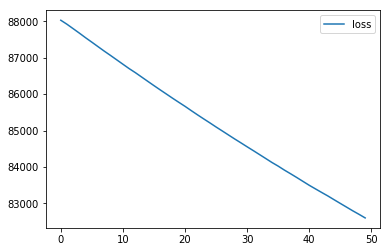

In [25]:
from matplotlib import pyplot

# Set batch_size to 7 to show that it doesn't have to be a factor or multiple of your sample size
history = model.fit(X_train, y_train,
              batch_size=72, nb_epoch=50,
              verbose = 1)

pyplot.plot(history.history['loss'], label='loss')
#pyplot.plot(history.history['val_loss'], label='val_loss')
pyplot.legend()
pyplot.show()

In [2]:
import keras
keras.__version__

C:\Users\langh\Miniconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.1.5'

In [ ]:
import numpy as np

def _load_data(data, n_prev = 100):  
    """
    data should be pd.DataFrame()
    """

    docX, docY = [], []
    for i in range(len(data)-n_prev):
        docX.append(data.iloc[i:i+n_prev].as_matrix())
        docY.append(data.iloc[i+n_prev].as_matrix())
    alsX = np.array(docX)
    alsY = np.array(docY)

    return alsX, alsY

def train_test_split(df, test_size=0.1):  
    """
    This just splits data to training and testing parts
    """
    ntrn = round(len(df) * (1 - test_size))

    X_train, y_train = _load_data(df.iloc[0:ntrn])
    X_test, y_test = _load_data(df.iloc[ntrn:])

    return (X_train, y_train), (X_test, y_test)

In [ ]:
from keras.datasets import imdb
from keras.preprocessing import sequence
from keras import layers
from keras.models import Sequential

# Load data
(x_train, y_train), (x_test, y_test) = df.drop(['1, 2'], axis=1, inplace=False)

# Reverse sequences
x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# Pad sequences
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

model = Sequential()
model.add(layers.Embedding(max_features, 128))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [77]:
dft = pd.DataFrame(df.SKU.unique(), columns=['SKU'])
dft.sort_values('SKU', ascending=True, inplace=True)
dft.set_index('SKU', inplace=True)
for input_col in input_cols:
    df2=df.groupby('SKU', as_index=True)[input_col].agg({input_col:(lambda x: list(x))})
    dft=df2.merge(dft, left_index=True, right_index=True, how='inner').dropna()

print(dft.loc[101])
print(dft.columns)

C:\Users\langh\Miniconda3\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


PROMOTION             [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, ...
RAIN INTENSITY        [3, 1, 4, 0, 1, 5, 3, 5, 3, 5, 4, 0, 4, 0, 2, ...
MAX TEMP              [26.57, 28.43, 28.57, 28.86, 28.43, 27.71, 26....
AVG TEMP              [21.43, 22.71, 22.43, 23.0, 22.57, 22.14, 21.4...
MIN TEMP              [16.14, 17.29, 16.43, 17.14, 16.71, 16.14, 16....
REAL PRICE            [30.71, 30.5, 30.5, 30.5, 29.93, 29.5, 29.5, 2...
UNITS                 [154, 157, 149, 134, 143, 145, 154, 147, 284, ...
NetCost               [27.94, 27.94, 27.94, 27.94, 27.94, 27.94, 27....
Competitor's price    [32.55, 32.55, 32.55, 32.55, 32.55, 32.55, 32....
SYSTEM PRICE          [28.11, 30.5, 30.5, 30.5, 29.5, 29.5, 29.5, 29...
Name: 101, dtype: object
Index(['PROMOTION', 'RAIN INTENSITY', 'MAX TEMP', 'AVG TEMP', 'MIN TEMP',
       'REAL PRICE', 'UNITS', 'NetCost', 'Competitor's price', 'SYSTEM PRICE'],
      dtype='object')
